In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import json
from sklearn import preprocessing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
import geopandas as gpd
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
sns.set_style("whitegrid")

In [2]:
solo_living = pd.read_csv('scratchpad/wards_household_data.csv')

In [3]:
solo_living.head()

,Region code,Region name,County code,County name,Local authority code,Local authority name,Ward code,Ward name,Unnamed: 8,Persons,Persons.1,Persons.2,Unnamed: 12,Hectares,Persons per hectare,Unnamed: 15,Households,Persons per household
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All usual residents,Household residents,Communal establishment residents,NaN,Area,Population density,NaN,Households with at least one usual resident,Average household size
1,E12000001,NORTH EAST,NaN,NaN,E06000047,County Durham UA,E05007955,Annfield Plain,NaN,"7,774","7,717",57,NaN,799,9.7,NaN,"3,522",2.2
2,E12000001,NORTH EAST,NaN,NaN,E06000047,County Durham UA,E05007956,Aycliffe East,NaN,"6,280","6,234",46,NaN,"1,336",4.7,NaN,"2,787",2.2
3,E12000001,NORTH EAST,NaN,NaN,E06000047,County Durham UA,E05007957,Aycliffe North,NaN,"7,751","7,611",140,NaN,337,23,NaN,"3,271",2.3
4,E12000001,NORTH EAST,NaN,NaN,E06000047,County Durham UA,E05007958,Aycliffe West,NaN,"7,457","7,457",0,NaN,288,25.9,NaN,"3,335",2.2


In [4]:
solo_living = solo_living.drop(solo_living.index[0])
solo_living.head()
solo_living['Persons per household'] = solo_living['Persons per household'].astype('float32')

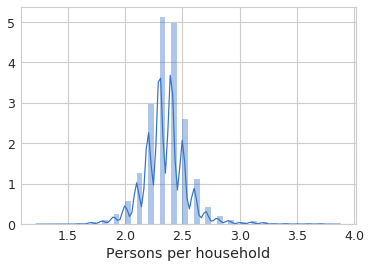

In [5]:
sns.distplot(solo_living['Persons per household'])

In [6]:
household_size = solo_living[['Ward code','Persons per household']].dropna()

In [7]:
data = pd.read_csv('scratchpad/All_data_aggregated_ward_level.csv')

In [8]:
len(data)

414

In [9]:
selected_ward_data= data[['GSS_CODE','WD17CD','GLUD_Area of Greenspace PCT','TreeScore',
                          'depression_Prevalence','diabetes_Prevalence','h_nutrients_calories_norm',
                          'avg_age','people_per_sq_km','third_places','All_jsa','Median 2012/13','bscore',
                          'IMD','nature_tags_score','h_nutrients_weight_norm']].copy()

In [10]:
df = pd.read_csv('scratchpad/Jan_clubcard2nutrients.csv.bz2', compression='bz2', header=0, sep=',', quotechar='"')

In [11]:
thresh_bottom_weight = np.mean(df['weight']) - 2*np.std(df['weight'])
thresh_top_weight = np.mean(df['weight']) + 2*np.std(df['weight'])

In [12]:
test = df[ (df['weight'] < 600) &  (df['weight'] > 100) ]
# test = df[ (df['weight'] < thresh_top_weight) & (df['weight'] > thresh_bottom_weight) ].copy()

In [13]:
nutrient  = [
 'h_items_norm',
 'h_items_weight_norm',
 'h_nutrients_calories_norm',
 'weight']
Tesco = test[['clubcard_number','h_nutrients_calories_norm', 'volume','osward','f_energy_alcohol' , 'h_items_norm' , 'h_items_weight_norm','weight']].copy()
Tesco = Tesco.dropna()
features_to_normalize = ['h_nutrients_calories_norm','h_items_norm','h_items_weight_norm','weight']
Tesco[features_to_normalize] = Tesco[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [14]:
# Tesco['Household'] =  0.9230 + 0.3245*Tesco['h_items_norm'] -0.4821*Tesco['h_items_weight_norm'] -0.5849*Tesco['h_nutrients_calories_norm']
Tesco['Household'] =  0.7321  + 0.2529*Tesco['weight'] - 0.7391*Tesco['h_nutrients_calories_norm']

In [15]:
thresh_bottom_household = np.mean(Tesco['Household']) - 2*np.std(Tesco['Household'])
thresh_top_household = np.mean(Tesco['Household']) + 2*np.std(Tesco['Household'])

Tesco_filtered = Tesco[ (Tesco['Household'] > thresh_bottom_household) &  (Tesco['Household'] < thresh_top_household) ].copy()

In [16]:
Tesco_filtered

,clubcard_number,h_nutrients_calories_norm,volume,osward,f_energy_alcohol,h_items_norm,h_items_weight_norm,weight,Household
0,Y/5lY9Ju1e5kIbDEX01AH2l2Dgg9EDxqiONTxlA0HNg++b...,0.692844,0.000000,E05000109,0.000000,0.613717,0.710430,0.443334,0.332138
1,eplFbOh7ODq0IfiGU9o8QuvQRZ39V7w2KBHnJw3QeMJNn5...,0.735186,68.571429,E05000109,0.054810,0.702776,0.417331,0.509327,0.317533
2,qMy5L60zed6nIOv+d4pZPJIVIZ5a0nBRUG/L3stsuC6mfh...,0.793677,99.428571,E05000109,0.356552,0.693431,0.452370,0.522611,0.277662
3,mpofO+CwzZSS1Ud5qlp4y5YvetAj0Y40+qrjP7yVrZkThS...,0.424299,0.000000,E05000109,0.000000,0.000000,0.000000,0.049882,0.431115
4,pZm5keBQ23M7hN6vcFV8OQFafmI8WiC12C0pXz8eIkJJ93...,0.623245,0.000000,E05000109,0.000000,0.214432,0.261454,0.299915,0.347308
...,...,...,...,...,...,...,...,...,...
886978,qRJFX/fNb/G+r6HENKmXKdHD+QGQcRAkHAzig4HuiW6+lQ...,0.709671,0.000000,E05000330,0.000000,0.488569,0.459335,0.698264,0.384174
886980,q9S1LAKmXfVT/FkdoQ0A9pY83kyb6uPdMCvkFraYJ6BrwT...,0.439324,0.000000,E05000060,0.000000,0.540902,0.550194,0.422931,0.514355
886981,0tEjOqzRamV+Eam5tm5klF8btuzaoJRPk+zi+heZx/MhVl...,0.668793,113.600000,E05000060,0.000000,0.385673,0.239684,0.866657,0.456972
886982,Cy8+5LWiFIMFS0UKMINEeDxMMLN5uWl87Jo8Lbc54srJca...,0.732588,101.950000,E05000060,0.019576,0.872216,0.831285,0.567731,0.334224


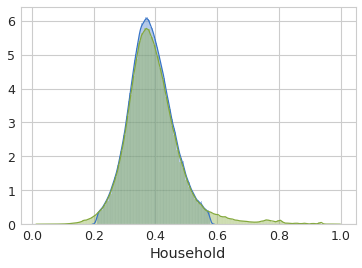

In [17]:
sns.distplot(Tesco_filtered['Household'],bins=100)
sns.distplot(Tesco['Household'],bins=100)

In [18]:
import math
def solo(x,Thresh):
    if x<= Thresh:
        return 1
    else:
        return 0 
def getThreshold(array, frac):
    array.sort()
    threshIndex = int(frac * len(array))
    return array[threshIndex]
    
def getWardRankings(df,frac):
#     Thresh  = np.min(df['Household']) +  frac * (np.max(df['Household']) - np.min(df['Household']))
    Thresh  = getThreshold(df['Household'].tolist(),frac)
    print(Thresh)
    df['solo'] = df['Household'].apply(lambda x: solo(x,Thresh))
    print("Total number of solo households: ", np.sum(df['solo']))
    Ward_level_estimate = {}   
    for name , group in df.groupby('osward'):
        soloHouses = np.sum(group['solo'])
        fraction = float(soloHouses)/ len(group)
        Ward_level_estimate[name] = fraction
        
    sorted_wards = sorted(Ward_level_estimate.items(), key=lambda item: item[1] , reverse= True)
    return [k[0] for k in sorted_wards]

def Distance(list1, list2):
    Footrule = 0.0
    for i in range(len(list1)):
        for j in range(len(list1)):
            if list2[j] == list1[i]:
                Footrule = Footrule + float((abs(j - i))) * float(math.exp(-(1 - (float(abs(j - i)))/float(len(list1)))))
    return Footrule/2

def calculateSolo(fr, to, intervals, df):
    scratch_df = df.copy()
    distances = []
    percentages = np.arange(fr, to , intervals)
    First = getWardRankings(scratch_df, percentages[0])
    for frac in percentages[1:]:
        new_order = getWardRankings(scratch_df, frac)
        distances.append(Distance(First,new_order))
        First = new_order
    return distances, percentages[1:]
        
        
def getWardsolo(df):
    Ward_level_estimate = {'wardCode':[] , 'soloFraction':[]}   
    for name , group in df.groupby('osward'):
        soloHouses = np.sum(group['solo'])
        fraction = float(soloHouses)/ len(group)
        Ward_level_estimate['wardCode'].append(name)
        Ward_level_estimate['soloFraction'].append(fraction)
    return pd.DataFrame.from_dict(Ward_level_estimate)

In [19]:
array = [1, 4, 5,  2, 5 , 7 , 10 , 12]
getThreshold(array , 0.3)

4

In [20]:
distance , percentages = calculateSolo(0.05 , 0.9 , 0.01, Tesco_filtered)

0.273950516132934
Total number of solo households:  35956
0.28007545612216683
Total number of solo households:  43147
0.2853834818079972
Total number of solo households:  50339
0.29017880545580343
Total number of solo households:  57530
0.29447134915616424
Total number of solo households:  64721
0.29841073808813046
Total number of solo households:  71912
0.30215891987777843
Total number of solo households:  79103
0.30553127202648056
Total number of solo households:  86294
0.3087501103136413
Total number of solo households:  93485
0.3117147557888659
Total number of solo households:  100677
0.31454986335844526
Total number of solo households:  107868
0.3171892660951686
Total number of solo households:  115059
0.31976021643299557
Total number of solo households:  122250
0.3222635204935441
Total number of solo households:  129441
0.32460678142691296
Total number of solo households:  136632
0.3269035241219562
Total number of solo households:  143824
0.3291198092564232
Total number of solo h

In [21]:
Distance(['a', 'b' , 'c' , 'd' , 'e'],['d', 'c' , 'a' , 'd' , 'e'])

1.778956187206096

In [22]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

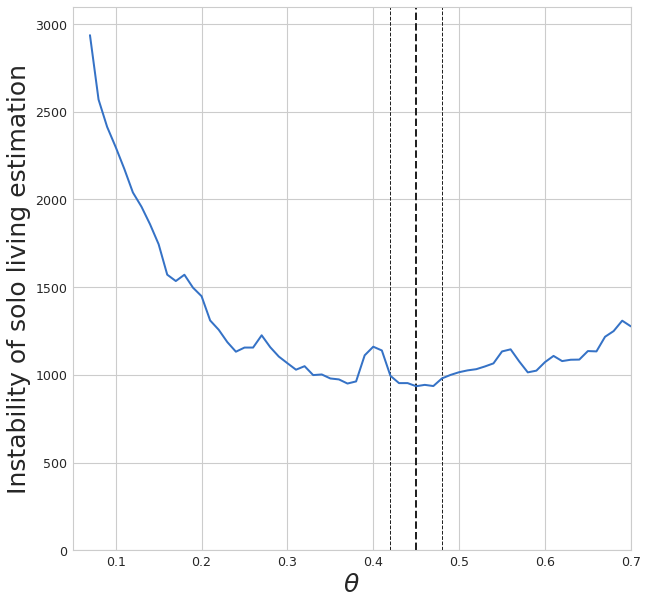

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style('whitegrid',{'axes.grid' : False})
# plt.plot(percentages, distance)
plt.plot(percentages[1:], smooth(distance,3)[1:],linewidth=2)
plt.ylim(0, 3100)
plt.xlim(0.05, 0.7)
# plt.vlines(0.45,0 , 65000 , linestyles = '--')
plt.vlines(0.42,0 , 65000 , linestyles = '--',linewidth=1)
plt.vlines(0.48,0 , 65000 , linestyles = '--',linewidth=1)
plt.vlines(0.45,0 , 65000 , linestyles = '--',linewidth=2)
plt.xlabel(r'$\theta$',fontsize=25)
plt.ylabel('Instability of solo living estimation', fontsize=25)
plt.show()

In [24]:
len(Tesco_filtered)

719115

In [25]:
Thresh  = np.min(Tesco_filtered['Household']) +  0.45 * (np.max(Tesco_filtered['Household']) - np.min(Tesco_filtered['Household']))
Tesco_filtered['solo'] = Tesco_filtered['Household'].apply(lambda x: solo(x,Thresh))
ward_predicted_solo = getWardsolo(Tesco_filtered)

In [26]:
ward_predicted_solo['rank'] = ward_predicted_solo['soloFraction'].rank(ascending=True,method ='first')
ward_predicted_solo.head()

,wardCode,soloFraction,rank
0,E05000026,0.391892,80.0
1,E05000027,0.469027,242.0
2,E05000028,0.448790,198.0
3,E05000029,0.439516,176.0
4,E05000030,0.462121,227.0


In [27]:
ward_predicted_solo[ward_predicted_solo['rank']==1]

,wardCode,soloFraction,rank
489,E05009293,0.2,1.0


In [28]:
wards_shape = gpd.read_file('../Data/Geo_Data/wards_london_2016/London-wards-2018_ESRI/London_Ward.shp')
wards_shape.head()

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((516401.596 160201.802, 516407.302 16..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.0,"POLYGON ((519552.998 164295.600, 519508.096 16..."
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.390,0.0,"POLYGON ((518107.499 167303.399, 518114.301 16..."
3,Alexandra,E05000400,Kingston upon Thames,E09000021,268.506,0.0,"POLYGON ((520336.700 165105.498, 520332.198 16..."
4,Beverley,E05000402,Kingston upon Thames,E09000021,187.821,0.0,"POLYGON ((521201.203 169275.505, 521204.303 16..."


In [29]:
solo_wards_shape = pd.merge(wards_shape , ward_predicted_solo , left_on='GSS_CODE' , right_on='wardCode')
len(solo_wards_shape)

657

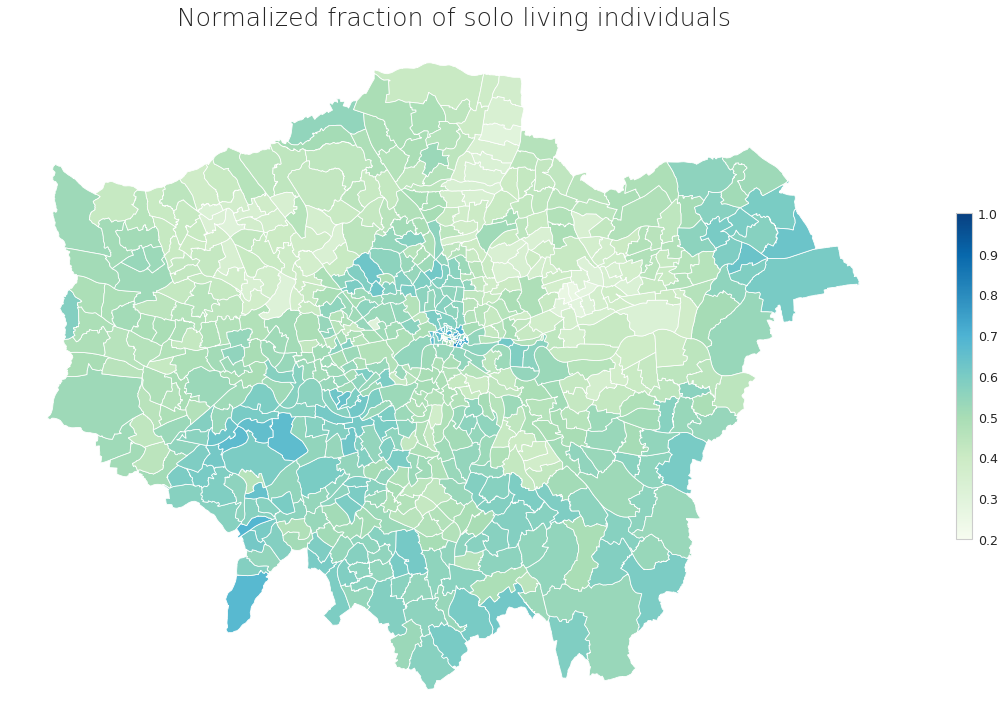

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Normalized fraction of solo living individuals', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=solo_wards_shape['soloFraction'].min(), vmax=solo_wards_shape['soloFraction'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
solo_wards_shape.plot(ax=ax,column='soloFraction', cmap='GnBu', linewidth=0.8)

In [31]:
len(ward_predicted_solo)

658

In [32]:
data_testing = pd.merge(data, solo_wards_shape , left_on = 'WD17CD' , right_on='wardCode')

In [33]:
len(data_testing)

414

In [34]:
ward_demographics = pd.read_csv('scratchpad/london_wards_demographics.csv')

In [35]:
ward_demographics.head()

,AreaSqKm,ArtsEmploy,BornUK,DistCentre,EntireAirb,GSS_CODE,GiniSimpso,GrenSpace,HapScore,IMDScore,...,zt_ArtsEmploy_ratio,z_NotBornUK_ratio,z_PercLev4Qu,z_LivingEnSc,zt_GrenSpace,zt_NoCTFtoH,z_NoHouses_ratio,z_NoOwndDwel_ratio,zt_MedHPrice,zt_NoPropsSld
0,7.6,1200.0,8772,17356.185490,0.0,E05000405,0.236819,75.7,7.7,11.06,...,1.372649,-1.707082,-0.961777,-1.478781,2.204287,-0.061470,1.166054,1.502240,-0.471274,0.102316
1,2.6,200.0,7264,14010.967045,0.0,E05000414,0.430849,33.1,7.5,12.33,...,0.850925,-0.501547,-0.595987,-0.632345,0.487091,-0.453636,1.124537,1.157384,-0.470800,-0.628047
2,1.5,100.0,7165,12118.028513,0.0,E05000401,0.315671,10.8,7.9,11.97,...,0.684129,-0.669858,0.836045,-0.248193,-0.950215,0.681043,-0.185295,0.240564,-0.090954,0.118909
3,2.7,100.0,6731,12607.720507,0.0,E05000400,0.457574,43.5,7.3,8.75,...,0.689156,-0.417921,-0.385852,-1.207759,0.977778,0.480568,1.492871,1.662734,0.187990,-0.758520
4,1.9,300.0,6830,10260.442758,0.0,E05000402,0.488281,26.5,7.8,11.45,...,0.953970,-0.047748,0.314599,-0.667342,0.134340,0.600112,0.790886,0.759403,0.053452,-0.482980


In [36]:
list(ward_demographics.columns)

['AreaSqKm',
 'ArtsEmploy',
 'BornUK',
 'DistCentre',
 'EntireAirb',
 'GSS_CODE',
 'GiniSimpso',
 'GrenSpace',
 'HapScore',
 'IMDScore',
 'IncomeScor',
 'LivingEnSc',
 'MedHPrice',
 'NESW',
 'No4sqCheck',
 'NoCTFtoH',
 'NoDwelling',
 'NoEmployee',
 'NoFlats',
 'NoHotels',
 'NoHouses',
 'NoOSPOIs',
 'NoOwndDwel',
 'NoPropsSld',
 'NotBornUK',
 'PTALScore',
 'PercLev4Qu',
 'PopDen',
 'WARD_CODE',
 'WARD_NAME',
 'wards_boro',
 'z_distCent1',
 'zt_PTALScore',
 'zt_NoOSPOIs',
 'zt_PopDen',
 'z_IncomeScor',
 'zt_NoEmployee_ratio',
 'zt_GiniSimpso',
 'zt_ArtsEmploy_ratio',
 'z_NotBornUK_ratio',
 'z_PercLev4Qu',
 'z_LivingEnSc',
 'zt_GrenSpace',
 'zt_NoCTFtoH',
 'z_NoHouses_ratio',
 'z_NoOwndDwel_ratio',
 'zt_MedHPrice',
 'zt_NoPropsSld']

In [37]:
airbnb_cols = ['HapScore',
               'IMDScore',
               'DistCentre', 
               'PTALScore', 
               'zt_NoOSPOIs',
               'zt_PopDen',
               'z_IncomeScor',
               'zt_NoEmployee_ratio',
               'zt_GiniSimpso',
               'zt_ArtsEmploy_ratio',
               'z_NotBornUK_ratio',
               'z_PercLev4Qu',
               'z_LivingEnSc',
               'zt_GrenSpace',
               'zt_NoCTFtoH',
               'z_NoHouses_ratio',
               'z_NoOwndDwel_ratio',
               'zt_MedHPrice',
               'zt_NoPropsSld']

In [38]:
data_testing_all = pd.merge(data_testing , ward_demographics , left_on='WD17CD', right_on='GSS_CODE')

In [39]:
data_testing_all['TreeScore_norm']

0      0.068589
1      0.075160
2      0.097131
3      0.068269
4      0.058179
         ...   
409    0.053676
410    0.064086
411    0.108148
412    0.066483
413    0.077796
Name: TreeScore_norm, Length: 414, dtype: float64

In [40]:
list(data_testing_all.columns)

['Unnamed: 0',
 'Unnamed: 0_x',
 'green_score',
 'GSS_CODE_x',
 'WD17CD',
 'GLUD_Area of Greenspace PCT',
 'LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT',
 'Unnamed: 0.1',
 'borough_name_x',
 'poly',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Tree',
 'TreeTotal',
 'TreeScore',
 'psoriasis_Prescriptions',
 'psoriasis_Prevalence',
 "Meniere's disease_Prescriptions",
 "Meniere's disease_Prevalence",
 "crohn's disease_Prescriptions",
 "crohn's disease_Prevalence",
 'gastroparesis_Prescriptions',
 'gastroparesis_Prevalence',
 'irritable bowel syndrome_Prescriptions',
 'irritable bowel syndrome_Prevalence',
 'parkinson_Prescriptions',
 'parkinson_Prevalence',
 'sleep apnea_Prescriptions',
 'sleep apnea_Prevalence',
 'interstitial cystitis_Prescriptions',
 'interstitial cystitis_Prevalence',
 'bipolar_Prescriptions',
 'bipolar_Prevalence',
 'hypothyroid

In [41]:
len(data_testing_all)

414

In [42]:
def norm(df,column):
    x = df[[column]].values.astype(float)

    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()

    # Create an object to transform the data to fit minmax processor
    x_scaled = min_max_scaler.fit_transform(x)
    return x_scaled

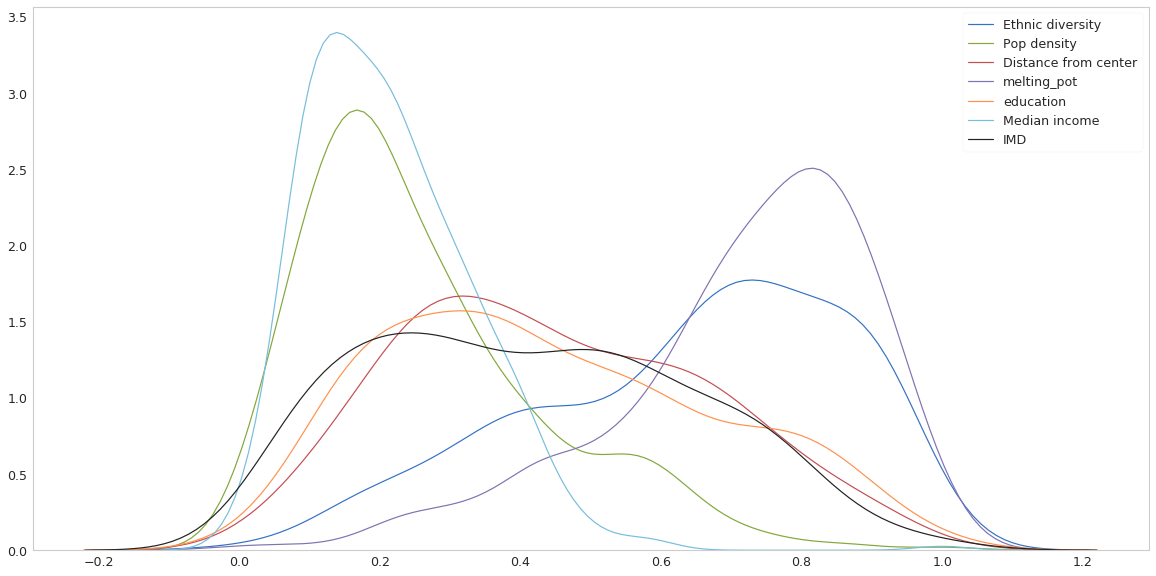

In [43]:
fig = plt.figure(figsize=(20,10))
sns.distplot(norm(data_testing_all,'zt_GiniSimpso'),hist=False,label='Ethnic diversity')
sns.distplot(norm(data_testing_all,'people_per_sq_km'),hist=False,label='Pop density')
sns.distplot(norm(data_testing_all,'z_distCent1'),hist=False,label='Distance from center')
sns.distplot(norm(data_testing_all,'z_NotBornUK_ratio'),hist=False,label='melting_pot')
sns.distplot(norm(data_testing_all,'z_PercLev4Qu'),hist=False,label='education')
sns.distplot(norm(data_testing_all,'Median 2012/13'),hist=False,label='Median income')
sns.distplot(norm(data_testing_all,'IMDScore'),hist=False,label='IMD')
plt.legend()
plt.show()

In [44]:
data_analysis = data_testing_all.copy()

In [45]:
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn import preprocessing

socio_economic = ['Median 2012/13','people_per_sq_km','z_distCent1']
bnb_cols     = ['HapScore',
                'IMDScore',
               'z_distCent1', 
               'zt_PTALScore', 
               'zt_NoOSPOIs',
               'zt_NoEmployee_ratio',
               'zt_ArtsEmploy_ratio',
               'z_NotBornUK_ratio',
               'z_PercLev4Qu',
               'z_LivingEnSc',
               'zt_GrenSpace',
               'zt_NoCTFtoH',
               'z_NoHouses_ratio',
               'z_NoOwndDwel_ratio',
               'zt_MedHPrice',
               'zt_NoPropsSld']
nutrient  = ['h_nutrients_calories_norm']
green = ['TreeScore_norm','GLUD_Area of Greenspace PCT','LCM_tree_pct','LCM_urban_pct','UA_Public Greenery PCT','StreetTrees_PCT']
beauty = ['bscore']

significant = ['zt_GiniSimpso' , 'z_PercLev4Qu' ]

interaction_terms = ['interaction_0']


interactions = [('z_distCent1','people_per_sq_km')]


for index , i in enumerate(interactions):
    sampled = data_testing_all[[i[0] , i[1]]]
    normalized_sampled = (sampled-sampled.min())/(sampled.max()-sampled.min())
    data_analysis['interaction_'+str(index)] = normalized_sampled[i[0]] * normalized_sampled[i[1]]

    

X_dims = socio_economic + significant + interaction_terms #socio_economic + bnb_cols
X_dims_base = ['people_per_sq_km','z_distCent1' , 'Median 2012/13'] + interaction_terms[:1]

print(X_dims)

print(X_dims_base)

Y_dims = ['rank']


min_max_scaler = preprocessing.MinMaxScaler() 

Y = np.array(data_analysis[Y_dims].values,dtype=np.float32)
X = np.array(data_analysis[X_dims].values,dtype=np.float32)
X_base =  np.array(data_analysis[X_dims_base].values,dtype=np.float32)

X = min_max_scaler.fit_transform(X)
X_base = min_max_scaler.fit_transform(X_base)
Y = min_max_scaler.fit_transform(Y)

['Median 2012/13', 'people_per_sq_km', 'z_distCent1', 'zt_GiniSimpso', 'z_PercLev4Qu', 'interaction_0']
['people_per_sq_km', 'z_distCent1', 'Median 2012/13', 'interaction_0']


In [46]:
# X_dims[16]

In [47]:
X_base = sm.add_constant(X_base)
print(X_dims_base)
model_solo_base = sm.OLS(Y, X_base).fit()

pred_solo_base = model_solo_base.predict(X_base)
model_solo_base.summary()

['people_per_sq_km', 'z_distCent1', 'Median 2012/13', 'interaction_0']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     53.69
Date:                Fri, 22 Jan 2021   Prob (F-statistic):           2.34e-36
Time:                        16:17:15   Log-Likelihood:                 10.278
No. Observations:                 414   AIC:                            -10.56
Df Residuals:                     409   BIC:                             9.574
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0308      0.067     -0.460      0.645      -0.162       0.101
x1             0.5422      0.143      3.782      0.000       0.260       0.824
x2             0.5175      0.101      5.114      0.000       0.319       0.716
x3             1.3592      0.105     12.978      0.000       1.153       1.565
x4            -0.4012      0.099     -4.044      0.000      -0.596      -0.206
==============================================================================
Omnibus:                        2.284   Durbin-Watson:                   1.173
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                2.176
Skew:                          -0.177   Prob(JB):                        0.337
Kurtosis:                       3.023   Cond. No.                         20.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[Text(0, 0.5, 'Median 2012/13'),
 Text(0, 1.5, 'people_per_sq_km'),
 Text(0, 2.5, 'z_distCent1'),
 Text(0, 3.5, 'zt_GiniSimpso'),
 Text(0, 4.5, 'z_PercLev4Qu'),
 Text(0, 5.5, 'interaction_0'),
 Text(0, 6.5, 'rank')]

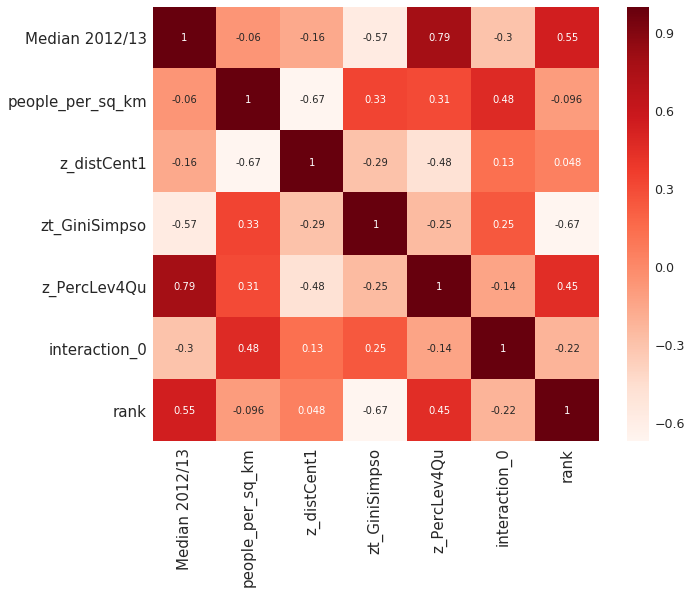

In [48]:
dims = X_dims + ['rank']
feats = data_analysis[dims]
fig, ax = plt.subplots(figsize=(10,8))         
corr = feats.corr(method='pearson')
sns.heatmap(corr, annot=True , ax=ax ,cmap='Reds' )
ax.set_xticklabels(corr.columns, fontsize=15)
ax.set_yticklabels(corr.columns, fontsize=15)

In [49]:
pearsonr(data_analysis['Median 2012/13'] , data_analysis['people_per_sq_km'])

(-0.05985279205368106, 0.22427771730825805)

In [50]:
X = sm.add_constant(X)
print(X_dims)
model_solo = sm.OLS(Y, X).fit()

pred_solo = model_solo.predict(X)
model_solo.summary()

['Median 2012/13', 'people_per_sq_km', 'z_distCent1', 'zt_GiniSimpso', 'z_PercLev4Qu', 'interaction_0']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     83.61
Date:                Fri, 22 Jan 2021   Prob (F-statistic):           6.71e-68
Time:                        16:17:15   Log-Likelihood:                 89.170
No. Observations:                 414   AIC:                            -164.3
Df Residuals:                     407   BIC:                            -136.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7391      0.086      8.548      0.000       0.569       0.909
x1            -0.4119      0.183     -2.250      0.025      -0.772      -0.052
x2             0.2719      0.121      2.251      0.025       0.034       0.509
x3             0.2557      0.093      2.759      0.006       0.074       0.438
x4            -0.8012      0.062    -12.958      0.000      -0.923      -0.680
x5             0.5632      0.089      6.353      0.000       0.389       0.738
x6            -0.2458      0.084     -2.933      0.004      -0.411      -0.081
==============================================================================
Omnibus:                        1.067   Durbin-Watson:                   1.475
Prob(Omnibus):                  0.587   Jarque-Bera (JB):                1.080
Skew:                           0.019   Prob(JB):                        0.583
Kurtosis:                       2.753   Cond. No.                         30.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
Residual = pred_solo - pred_solo_base
data_analysis['solo_pred'] = pred_solo

In [52]:
data_analysis['zeta_adds']  = data_analysis['zt_GiniSimpso'] + data_analysis['z_PercLev4Qu']

In [53]:
data_analysis['GSS_CODE_x']

0      E05000420
1      E05000571
2      E05000570
3      E05000572
4      E05000620
         ...    
409    E05000257
410    E05000314
411    E05000438
412    E05000439
413    E05000230
Name: GSS_CODE_x, Length: 414, dtype: object

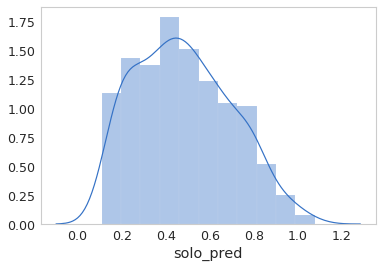

In [54]:
sns.distplot(data_analysis['solo_pred'])

In [55]:
pearsonr(data_analysis['zt_GiniSimpso'] , data_analysis['people_per_sq_km'])

(0.32770529522333885, 8.06615730300061e-12)

In [56]:
list(data_analysis.columns)

['Unnamed: 0',
 'Unnamed: 0_x',
 'green_score',
 'GSS_CODE_x',
 'WD17CD',
 'GLUD_Area of Greenspace PCT',
 'LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT',
 'Unnamed: 0.1',
 'borough_name_x',
 'poly',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Tree',
 'TreeTotal',
 'TreeScore',
 'psoriasis_Prescriptions',
 'psoriasis_Prevalence',
 "Meniere's disease_Prescriptions",
 "Meniere's disease_Prevalence",
 "crohn's disease_Prescriptions",
 "crohn's disease_Prevalence",
 'gastroparesis_Prescriptions',
 'gastroparesis_Prevalence',
 'irritable bowel syndrome_Prescriptions',
 'irritable bowel syndrome_Prevalence',
 'parkinson_Prescriptions',
 'parkinson_Prevalence',
 'sleep apnea_Prescriptions',
 'sleep apnea_Prevalence',
 'interstitial cystitis_Prescriptions',
 'interstitial cystitis_Prevalence',
 'bipolar_Prescriptions',
 'bipolar_Prevalence',
 'hypothyroid

In [57]:
data_slice = data_analysis[data_analysis['solo_pred'] > np.median(data_analysis['solo_pred'])]

In [58]:
data_slice['logit_good_solo'] = 0
mask = (data_slice['zeta_adds'] > np.median(data_slice['zeta_adds']))
data_slice['logit_good_solo'][mask] = 1

/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/work/sagarj/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d

In [59]:
from sklearn.linear_model import LogisticRegression
significant = ['depression_Prevalence' ,'IMD' ]

for col in significant:
    col_zscore = col + '_zscore'
    data_slice[col_zscore] = (data_slice[col] - data_slice[col].mean())/data_slice[col].std(ddof=0)
    
significant_zeta =  ['depression_Prevalence_zscore' ,'IMD_zscore' ]
Y_dims = ['logit_good_solo']
Y = np.array(data_slice[Y_dims].values,dtype=np.float32)
X = np.array(data_slice[significant_zeta].values,dtype=np.float32)
X = sm.add_constant(X)

logit_model=sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.537341
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.225     
Dependent Variable: y                AIC:              228.4592  
Date:               2021-01-22 16:17 BIC:              238.4573  
No. Observations:   207              Log-Likelihood:   -111.23   
Df Model:           2                LL-Null:          -143.48   
Df Residuals:       204              LLR p-value:      9.8681e-15
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const     -0.0814     0.1658   -0.4910   0.6234   -0.4063    0.2435
x1        -0.4073     0.1734   -2.3495   0.0188   -0.7470 

/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [60]:
# result.predict(X)

In [61]:
predicted = [1 if k > 0.5 else 0 for k in result.predict(X)]
labels = [k for k in Y ]

In [62]:
probs = result.predict(X)

In [63]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

auc = roc_auc_score(labels, predicted)
print(auc)

0.7392643764002987


In [64]:
confusion_matrix(predicted,labels)

array([[74, 24],
       [30, 79]])

In [65]:
auc

0.7392643764002987

In [66]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [67]:
fpr, tpr, thresholds = roc_curve(labels, predicted)

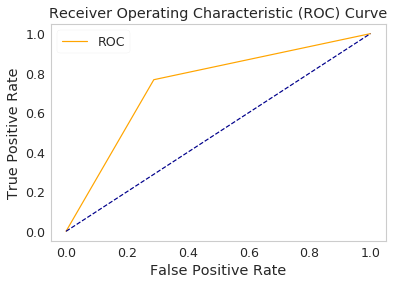

In [68]:
plot_roc_curve(fpr, tpr)

In [69]:
significant = ['solo_pred' , 'zeta_adds' ]
# Y_dims = ['IMD']
Y_dims = ['depression_Prevalence']
min_max_scaler = preprocessing.MinMaxScaler() 

Y = np.array(data_slice[Y_dims].values,dtype=np.float32)
X = np.array(data_slice[significant].values,dtype=np.float32)
X = min_max_scaler.fit_transform(X)
Y = min_max_scaler.fit_transform(Y)
X = sm.add_constant(X)

model_good_bad_solo = sm.OLS(Y, X).fit()
model_good_bad_solo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     4.501
Date:                Fri, 22 Jan 2021   Prob (F-statistic):             0.0122
Time:                        16:17:18   Log-Likelihood:                 97.103
No. Observations:                 207   AIC:                            -188.2
Df Residuals:                     204   BIC:                            -178.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3639      0.035     10.363      0.000       0.295       0.433
x1             0.1202      0.048      2.517      0.013       0.026       0.214
x2            -0.0505      0.043     -1.169      0.244      -0.136       0.035
==============================================================================
Omnibus:                       16.191   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.673
Skew:                           0.602   Prob(JB):                     8.82e-05
Kurtosis:                       3.846   Cond. No.                         6.91
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

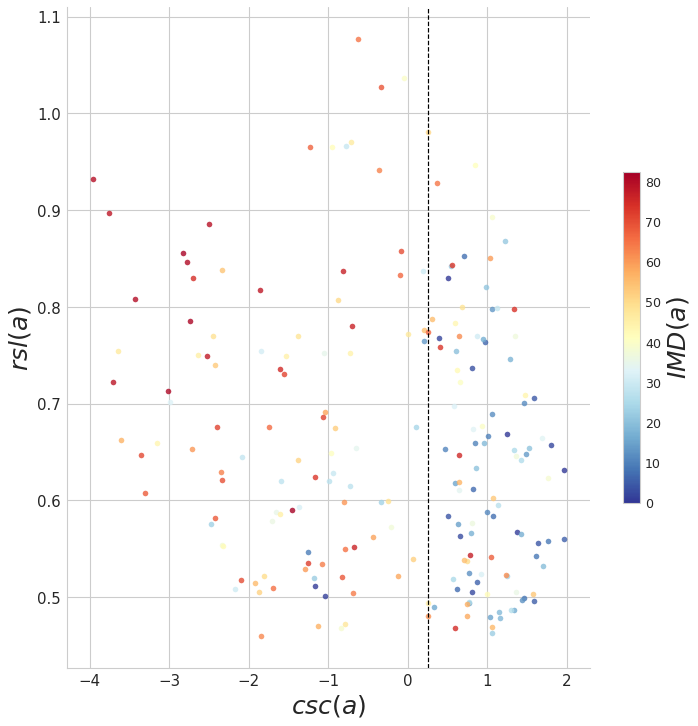

In [70]:
sns.set_style("whitegrid")
g= sns.lmplot( x='zeta_adds', y='solo_pred', data=data_slice, fit_reg=False, hue='IMD', legend=False, palette="RdYlBu_r",height=10)
ax = g.axes[0][0]

scalarmap = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=plt.Normalize(vmin=max(data_analysis['IMD']), vmax=min(data_analysis['IMD'])))
cbar = plt.colorbar(scalarmap,shrink=0.5)
cbar.set_label('$IMD(a)$', fontsize = 25)

# ax.axhline(np.min(data_slice['solo_pred']), ls='--',color='black')
ax.axvline(np.median(data_slice['zeta_adds']), ls='--',color='black')
ax.set_xlabel("$csc(a)$",fontsize=25)
ax.set_ylabel("$rsl(a)$",fontsize=25)
ax.tick_params(labelsize=15)

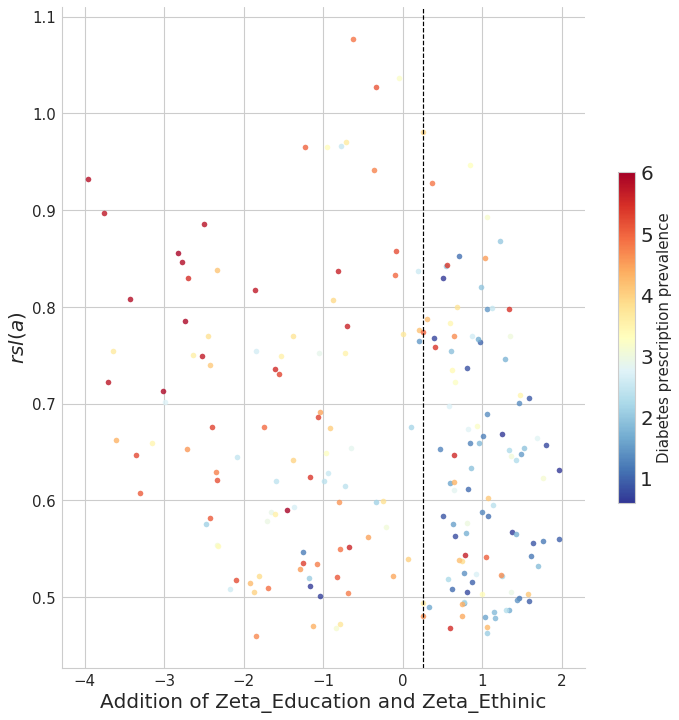

In [71]:
sns.set_style("whitegrid")
g= sns.lmplot( x='zeta_adds', y='solo_pred', data=data_slice, fit_reg=False, hue='IMD', legend=False, palette="RdYlBu_r",height=10)
ax = g.axes[0][0]

scalarmap = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=plt.Normalize(vmin=max(data_analysis['diabetes_Prevalence']), vmax=min(data_analysis['diabetes_Prevalence'])))
cbar = plt.colorbar(scalarmap,shrink=0.5)
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('Diabetes prescription prevalence', fontsize = 15)

# ax.axhline(np.min(data_slice['solo_pred']), ls='--',color='black')
ax.axvline(np.median(data_slice['zeta_adds']), ls='--',color='black')
ax.set_xlabel("Addition of Zeta_Education and Zeta_Ethinic",fontsize=20)
ax.set_ylabel("$rsl(a)$",fontsize=20)
ax.tick_params(labelsize=15)

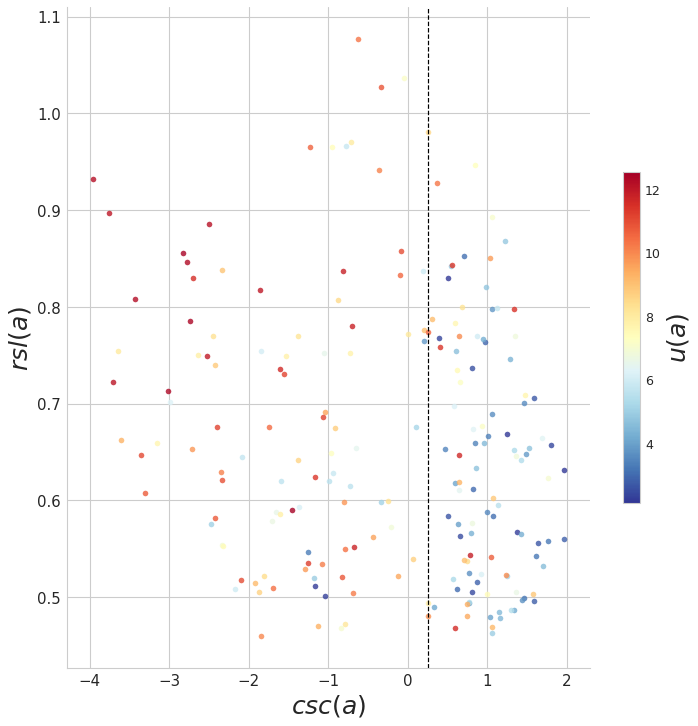

In [72]:
sns.set_style("whitegrid")
g= sns.lmplot( x='zeta_adds', y='solo_pred', data=data_slice, fit_reg=False, hue='IMD', legend=False, palette="RdYlBu_r",height=10)
ax = g.axes[0][0]

scalarmap = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=plt.Normalize(vmin=max(data_analysis['depression_Prevalence']), vmax=min(data_analysis['depression_Prevalence'])))
cbar = plt.colorbar(scalarmap ,shrink = 0.5)
cbar.set_label('$u(a)$', fontsize = 25)

# ax.axhline(np.min(data_slice['solo_pred']), ls='--',color='black')
ax.axvline(np.median(data_slice['zeta_adds']), ls='--',color='black')
ax.set_xlabel("$csc(a)$",fontsize=25)
ax.set_ylabel("$rsl(a)$",fontsize=25)
ax.tick_params(labelsize=15)

In [73]:
valid_wards = data_analysis[data_analysis['solo_pred'] > np.median(data_analysis['solo_pred'])]
len(valid_wards)

207

In [74]:
zeta_scores  = {}
pred_solo
for index , row in valid_wards.iterrows():
    zeta_scores[row['GSS_CODE_x']] = row['zeta_adds']

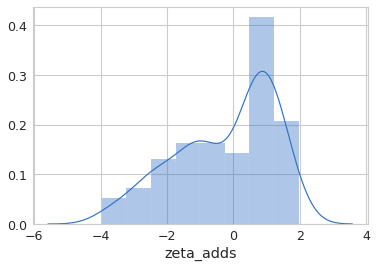

In [75]:
sns.distplot(valid_wards['zeta_adds'])

In [76]:
solo_wards_shape['creative_solo_class'] = 0.0
for index , row in solo_wards_shape.iterrows():
    if row['GSS_CODE'] in zeta_scores:
        print(zeta_scores[row['GSS_CODE']])
        solo_wards_shape.at[index,'creative_solo_class']= zeta_scores[row['GSS_CODE']]

-2.7410903628917818
-1.0804113029640163
-0.6919265810238654
0.7399072984185017
-2.7182512282923508
-2.7729930281743718
-2.5232744140470387
-2.4959740344616295
-3.963937296249578
-2.444175046783299
-0.9381447098137257
-1.7506222640402467
-2.6974857372498344
-1.0498615985399282
-1.3798881335371262
-2.342709483899528
-0.7249829550836026
-1.3817585801164354
-1.8645958215755616
-2.4197110239602266
-2.6349007040266876
-3.1515753674251044
-3.0153467374497165
0.25476517130797205
0.25046417517383923
0.30101574282408583
0.6493245262162275
0.5830556459323621
-2.331731374361678
0.85204173544038
1.055692642807054
1.1277565799584248
1.4263568939453415
0.6079402557341076
-3.3545652057258115
-2.1011189080019563
-3.6077895843962517
-3.6469174747873776
-2.353168497811704
-2.9847523485844354
-3.4345428329468035
-3.753666174422781
-3.3042272694697745
-3.7048132212754012
-2.8216354177039076
-0.4326445549350769
-1.0669247180302621
-1.5556220529929905
0.6405459664338342
-1.25117437312736
-2.090906563806091
-

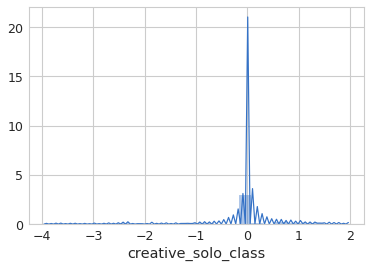

In [77]:
sns.distplot(solo_wards_shape['creative_solo_class'])

In [78]:
sorted_solo = solo_wards_shape.sort_values('creative_solo_class')
top = sorted_solo[:10]
bottom = sorted_solo[-10:]

In [79]:
top

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry,wardCode,soloFraction,rank,creative_solo_class
48,Biggin Hill,E05000107,Bromley,E09000006,828.039,0.0,"POLYGON ((540373.600 157530.397, 540361.199 15...",E05000107,0.590551,583.0,-3.963937
122,Cranham,E05000307,Havering,E09000016,655.501,0.0,"POLYGON ((558834.498 187553.803, 558756.599 18...",E05000307,0.632143,639.0,-3.753666
125,Gooshays,E05000310,Havering,E09000016,775.896,0.0,"POLYGON ((553968.403 191390.104, 553932.999 19...",E05000310,0.524217,395.0,-3.704813
116,Pettits,E05000317,Havering,E09000016,395.457,0.0,"POLYGON ((550598.003 189723.102, 550563.399 18...",E05000317,0.569697,538.0,-3.646917
115,Mawneys,E05000316,Havering,E09000016,304.261,0.0,"POLYGON ((548954.598 189063.301, 548965.003 18...",E05000316,0.505747,349.0,-3.607790
121,Harold Wood,E05000312,Havering,E09000016,758.973,0.0,"POLYGON ((557409.702 190379.904, 557359.803 19...",E05000312,0.603037,613.0,-3.434543
112,Elm Park,E05000308,Havering,E09000016,366.535,0.0,"POLYGON ((550857.500 184295.195, 550866.397 18...",E05000308,0.555256,500.0,-3.354565
124,Heaton,E05000314,Havering,E09000016,341.564,0.0,"POLYGON ((553968.403 191390.104, 553952.597 19...",E05000314,0.515358,377.0,-3.304227
64,Cray Valley West,E05000115,Bromley,E09000006,393.850,0.0,"POLYGON ((547448.003 170380.298, 547448.703 17...",E05000115,0.559420,510.0,-3.151575
65,Cray Valley East,E05000114,Bromley,E09000006,1327.866,0.0,"POLYGON ((545567.197 167057.000, 545585.699 16...",E05000114,0.533816,433.0,-3.015347


In [80]:
bottom

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry,wardCode,soloFraction,rank,creative_solo_class
516,Belsize,E05000128,Camden,E09000007,78.057,0.0,"POLYGON ((527541.803 184205.301, 527538.002 18...",E05000128,0.628014,635.0,1.581009
454,Avonmore and Brook Green,E05000252,Hammersmith and Fulham,E09000013,89.659,0.0,"POLYGON ((523236.001 179252.499, 523272.601 17...",E05000252,0.524866,399.0,1.612499
222,Ferndale,E05000421,Lambeth,E09000022,85.073,0.0,"POLYGON ((531000.804 175268.299, 530994.802 17...",E05000421,0.489838,298.0,1.632054
515,West Hampstead,E05000145,Camden,E09000007,88.729,0.0,"POLYGON ((524661.696 184630.999, 524651.101 18...",E05000145,0.598099,598.0,1.686691
491,Abbey Road,E05000630,City of Westminster,E09000033,109.492,0.0,"POLYGON ((527370.801 183470.701, 527336.897 18...",E05000630,0.561080,514.0,1.694192
501,Swiss Cottage,E05000144,Camden,E09000007,125.671,0.0,"POLYGON ((527370.801 183470.701, 527255.197 18...",E05000144,0.527621,410.0,1.763255
498,Little Venice,E05000639,City of Westminster,E09000033,63.733,0.0,"POLYGON ((526371.796 181700.498, 526348.603 18...",E05000639,0.540176,451.0,1.766658
494,Bayswater,E05000631,City of Westminster,E09000033,51.949,0.0,"POLYGON ((526032.198 181629.398, 526085.297 18...",E05000631,0.484985,286.0,1.805122
482,Lancaster Gate,E05000638,City of Westminster,E09000033,63.082,0.0,"POLYGON ((526231.902 181414.800, 526235.497 18...",E05000638,0.462138,228.0,1.961359
489,Bryanston and Dorset Square,E05000632,City of Westminster,E09000033,72.318,0.0,"POLYGON ((527921.900 181967.002, 527966.704 18...",E05000632,0.519352,385.0,1.966180


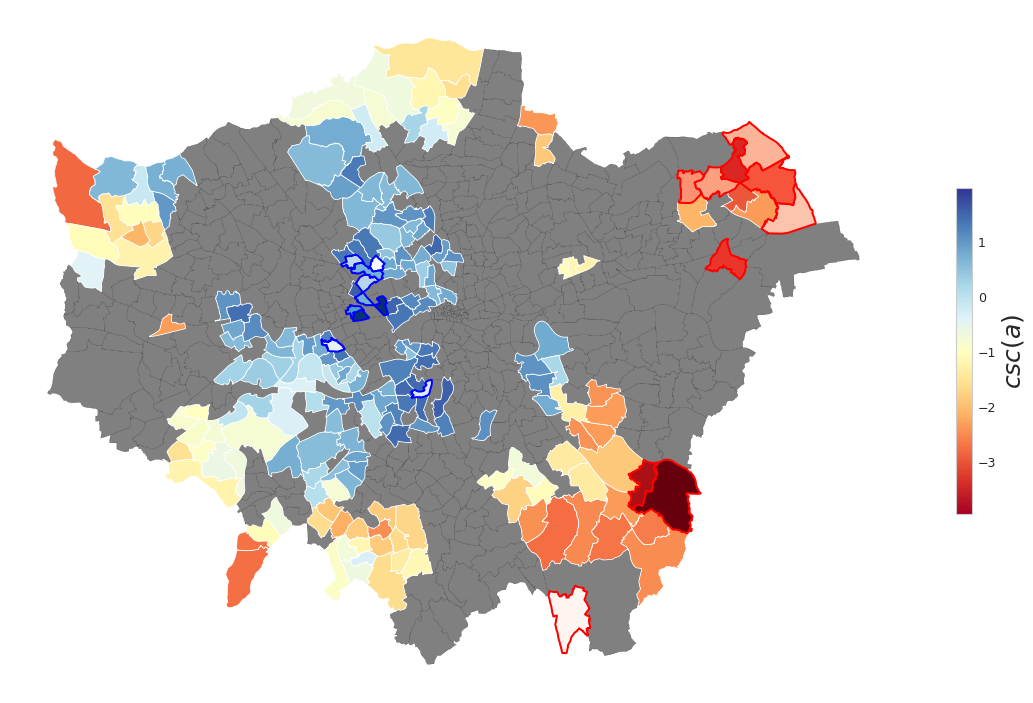

In [81]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
# ax.set_title('Good or Bad Solo', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=plt.Normalize(vmin=solo_wards_shape['creative_solo_class'].min(), vmax=solo_wards_shape['creative_solo_class'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
cbar.set_label('$csc(a)$', fontsize = 25)
solo_wards_shape[solo_wards_shape['creative_solo_class']==0.0].plot(ax=ax,color='gray', edgecolor='black')
# solo_wards_shape.plot(ax=ax,column='Solo_quality', cmap='RdYlBu', linewidth=0.8)
solo_wards_shape[solo_wards_shape['creative_solo_class']!=0.0].plot(ax=ax,column='creative_solo_class', cmap='RdYlBu', linewidth=0.8)

top.plot(column='creative_solo_class', cmap='Reds', linewidth=2,alpha=1 , ax=ax, edgecolor='Red')

bottom.plot(column='creative_solo_class', cmap='Blues', linewidth=2,alpha=1 , ax=ax, edgecolor='Blue')


In [82]:
solo_wards_shape

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry,wardCode,soloFraction,rank,creative_solo_class
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((516401.596 160201.802, 516407.302 16...",E05000405,0.677852,649.0,-2.741090
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.0,"POLYGON ((519552.998 164295.600, 519508.096 16...",E05000414,0.544000,462.0,-1.080411
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.390,0.0,"POLYGON ((518107.499 167303.399, 518114.301 16...",E05000401,0.605263,619.0,0.000000
3,Alexandra,E05000400,Kingston upon Thames,E09000021,268.506,0.0,"POLYGON ((520336.700 165105.498, 520332.198 16...",E05000400,0.578231,559.0,-0.691927
4,Beverley,E05000402,Kingston upon Thames,E09000021,187.821,0.0,"POLYGON ((521201.203 169275.505, 521204.303 16...",E05000402,0.560606,512.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
652,Aldgate,E05009289,City and County of the City of London,E09000001,11.230,0.0,"POLYGON ((533315.597 180988.802, 533305.703 18...",E05009289,0.562500,523.0,0.000000
653,Broad Street,E05009295,City and County of the City of London,E09000001,8.157,0.0,"POLYGON ((533005.698 181612.203, 533099.098 18...",E05009295,0.750000,656.0,0.000000
654,Coleman Street,E05009299,City and County of the City of London,E09000001,15.061,0.0,"POLYGON ((532552.797 181289.396, 532554.198 18...",E05009299,0.600000,607.0,0.000000
655,Portsoken,E05009308,City and County of the City of London,E09000001,6.288,0.0,"POLYGON ((533814.299 180968.898, 533757.202 18...",E05009308,0.514423,375.0,0.000000


In [83]:
good_bad_solo = solo_wards_shape[solo_wards_shape['creative_solo_class']!=0.0]
good_bad_solo['creative_solo_rank'] = good_bad_solo['creative_solo_class'].rank(ascending=True,method ='first')

/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [84]:
len(good_bad_solo)

207

In [85]:
good_bad_solo.to_file('RSOS_data/creative_solo.shp')

In [86]:
good_bad_solo.to_csv('RSOS_data/creative_solo.csv')

In [87]:
good_bad_solo[good_bad_solo['creative_solo_rank'] < 10]

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry,wardCode,soloFraction,rank,creative_solo_class,creative_solo_rank
48,Biggin Hill,E05000107,Bromley,E09000006,828.039,0.0,"POLYGON ((540373.600 157530.397, 540361.199 15...",E05000107,0.590551,583.0,-3.963937,1.0
64,Cray Valley West,E05000115,Bromley,E09000006,393.850,0.0,"POLYGON ((547448.003 170380.298, 547448.703 17...",E05000115,0.559420,510.0,-3.151575,9.0
112,Elm Park,E05000308,Havering,E09000016,366.535,0.0,"POLYGON ((550857.500 184295.195, 550866.397 18...",E05000308,0.555256,500.0,-3.354565,7.0
115,Mawneys,E05000316,Havering,E09000016,304.261,0.0,"POLYGON ((548954.598 189063.301, 548965.003 18...",E05000316,0.505747,349.0,-3.607790,5.0
116,Pettits,E05000317,Havering,E09000016,395.457,0.0,"POLYGON ((550598.003 189723.102, 550563.399 18...",E05000317,0.569697,538.0,-3.646917,4.0
121,Harold Wood,E05000312,Havering,E09000016,758.973,0.0,"POLYGON ((557409.702 190379.904, 557359.803 19...",E05000312,0.603037,613.0,-3.434543,6.0
122,Cranham,E05000307,Havering,E09000016,655.501,0.0,"POLYGON ((558834.498 187553.803, 558756.599 18...",E05000307,0.632143,639.0,-3.753666,2.0
124,Heaton,E05000314,Havering,E09000016,341.564,0.0,"POLYGON ((553968.403 191390.104, 553952.597 19...",E05000314,0.515358,377.0,-3.304227,8.0
125,Gooshays,E05000310,Havering,E09000016,775.896,0.0,"POLYGON ((553968.403 191390.104, 553932.999 19...",E05000310,0.524217,395.0,-3.704813,3.0


In [88]:
good_bad_solo[good_bad_solo['creative_solo_rank'] > max(good_bad_solo['creative_solo_rank']) - 15]

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry,wardCode,soloFraction,rank,creative_solo_class,creative_solo_rank
222,Ferndale,E05000421,Lambeth,E09000022,85.073,0.0,"POLYGON ((531000.804 175268.299, 530994.802 17...",E05000421,0.489838,298.0,1.632054,200.0
228,Herne Hill,E05000423,Lambeth,E09000022,203.038,0.0,"POLYGON ((532101.701 176563.699, 532111.603 17...",E05000423,0.478355,272.0,1.569142,196.0
439,Bedford,E05000611,Wandsworth,E09000032,180.480,0.0,"POLYGON ((528310.498 171782.997, 528306.401 17...",E05000611,0.599636,604.0,1.473617,193.0
454,Avonmore and Brook Green,E05000252,Hammersmith and Fulham,E09000013,89.659,0.0,"POLYGON ((523236.001 179252.499, 523272.601 17...",E05000252,0.524866,399.0,1.612499,199.0
482,Lancaster Gate,E05000638,City of Westminster,E09000033,63.082,0.0,"POLYGON ((526231.902 181414.800, 526235.497 18...",E05000638,0.462138,228.0,1.961359,206.0
489,Bryanston and Dorset Square,E05000632,City of Westminster,E09000033,72.318,0.0,"POLYGON ((527921.900 181967.002, 527966.704 18...",E05000632,0.519352,385.0,1.966180,207.0
491,Abbey Road,E05000630,City of Westminster,E09000033,109.492,0.0,"POLYGON ((527370.801 183470.701, 527336.897 18...",E05000630,0.561080,514.0,1.694192,202.0
492,Marylebone High Street,E05000641,City of Westminster,E09000033,100.107,0.0,"POLYGON ((528633.103 182307.604, 528728.201 18...",E05000641,0.512644,370.0,1.523206,195.0
494,Bayswater,E05000631,City of Westminster,E09000033,51.949,0.0,"POLYGON ((526032.198 181629.398, 526085.297 18...",E05000631,0.484985,286.0,1.805122,205.0
498,Little Venice,E05000639,City of Westminster,E09000033,63.733,0.0,"POLYGON ((526371.796 181700.498, 526348.603 18...",E05000639,0.540176,451.0,1.766658,204.0


In [89]:
set(solo_wards_shape['DISTRICT'])

{'Barking and Dagenham',
 'Barnet',
 'Bexley',
 'Brent',
 'Bromley',
 'Camden',
 'City and County of the City of London',
 'City of Westminster',
 'Croydon',
 'Ealing',
 'Enfield',
 'Greenwich',
 'Hackney',
 'Hammersmith and Fulham',
 'Haringey',
 'Harrow',
 'Havering',
 'Hillingdon',
 'Hounslow',
 'Islington',
 'Kensington and Chelsea',
 'Kingston upon Thames',
 'Lambeth',
 'Lewisham',
 'Merton',
 'Newham',
 'Redbridge',
 'Richmond upon Thames',
 'Southwark',
 'Sutton',
 'Tower Hamlets',
 'Waltham Forest',
 'Wandsworth'}

In [90]:
solo_wards_shape[solo_wards_shape['DISTRICT'] == 'Tower Hamlets']

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry,wardCode,soloFraction,rank,creative_solo_class
519,St. Katharine's & Wapping,E05009330,Tower Hamlets,E09000030,149.089,42.323,"POLYGON ((533669.796 180263.399, 533604.702 18...",E05009330,0.561685,519.0,0.0
520,Shadwell,E05009332,Tower Hamlets,E09000030,64.273,0.000,"POLYGON ((534643.901 180961.500, 534636.002 18...",E05009332,0.466341,236.0,0.0
521,Island Gardens,E05009324,Tower Hamlets,E09000030,150.812,44.334,"POLYGON ((536860.602 179019.695, 536854.600 17...",E05009324,0.544700,464.0,0.0
522,Canary Wharf,E05009323,Tower Hamlets,E09000030,164.207,22.894,"POLYGON ((536853.000 179077.799, 536843.799 17...",E05009323,0.590619,584.0,0.0
523,Blackwall & Cubitt Town,E05009318,Tower Hamlets,E09000030,188.125,52.756,"POLYGON ((537734.900 179037.900, 537752.602 17...",E05009318,0.563889,529.0,0.0
524,Poplar,E05009328,Tower Hamlets,E09000030,71.040,1.509,"POLYGON ((537119.604 180826.398, 537113.997 18...",E05009328,0.477545,265.0,0.0
525,Spitalfields & Banglatown,E05009333,Tower Hamlets,E09000030,90.895,0.000,"POLYGON ((533574.096 182138.803, 533614.703 18...",E05009333,0.505000,345.0,0.0
526,St. Peter's,E05009331,Tower Hamlets,E09000030,108.391,0.000,"POLYGON ((534407.301 182294.298, 534407.498 18...",E05009331,0.456651,211.0,0.0
527,Bethnal Green,E05009317,Tower Hamlets,E09000030,121.357,0.000,"POLYGON ((534956.999 182017.897, 534964.700 18...",E05009317,0.417118,129.0,0.0
528,St. Dunstan's,E05009329,Tower Hamlets,E09000030,67.907,0.000,"POLYGON ((535976.896 181153.205, 535978.999 18...",E05009329,0.452848,201.0,0.0


In [91]:
len(wards_shape)

657

In [92]:
solo_shape = pd.merge(wards_shape , data_testing_all , left_on='GSS_CODE' , right_on='WD17CD')
len(solo_shape)

414

In [93]:
islingtonWards = ['E05000366',
 'E05000367',
 'E05000368',
 'E05000369',
 'E05000370',
 'E05000371',
 'E05000372',
 'E05000373',
 'E05000374',
 'E05000375',
 'E05000376',
 'E05000377',
 'E05000378',
 'E05000379',
 'E05000380',
 'E05000381']

In [94]:
solo_shape['rank']

0      649.0
1      462.0
2      559.0
3      475.0
4      560.0
       ...  
409    130.0
410    218.0
411    227.0
412    176.0
413    110.0
Name: rank, Length: 414, dtype: float64

In [95]:
solo_shape['Solo_area'] = pd.qcut(solo_shape['rank'], 4, labels=["low_solo", 'mid1' ,' mid2' ,"high_solo"])

Text(0, 0.5, 'Frequency')

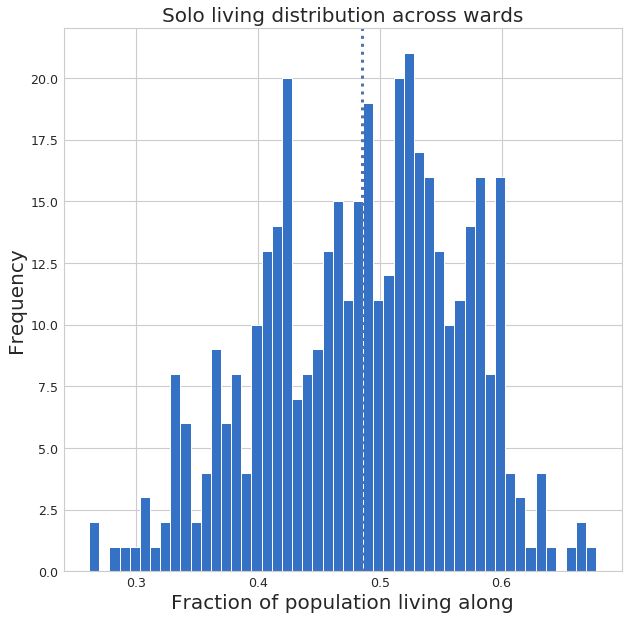

In [96]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.set(font_scale=2)
# sns.distplot(Data['Household'] ,kde_kws={"color": "b", "lw": 2, "label": "Solo living distribution"},bins=50,kde=True)
plt.hist(solo_shape['soloFraction'],bins=50)
ax.axvline(x=np.mean(solo_shape['soloFraction']), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
plt.title("Solo living distribution across wards" , fontsize = 20)
plt.xlabel("Fraction of population living along" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

Text(0, 0.5, 'Frequency')

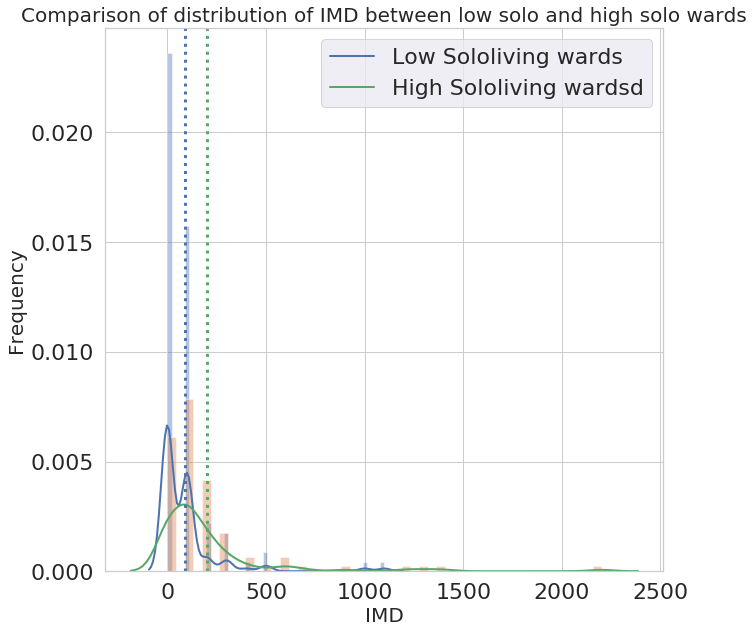

In [97]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.set(font_scale=2)
low_vals = solo_shape[solo_shape['Solo_area'] == 'low_solo']['ArtsEmploy']
high_vals = solo_shape[solo_shape['Solo_area'] == 'high_solo']['ArtsEmploy']
sns.distplot(low_vals ,kde_kws={"color": "b", "lw": 2, "label": "Low Sololiving wards"},bins=50,norm_hist=True)
sns.distplot(high_vals , kde_kws={"color": "g", "lw": 2, "label": "High Sololiving wardsd"},bins=50,norm_hist=True)
ax.axvline(x=np.mean(low_vals), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.mean(high_vals), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.title("Comparison of distribution of IMD between low solo and high solo wards" , fontsize = 20)
plt.xlabel("IMD" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [98]:
list(solo_shape.columns)

['NAME_x',
 'GSS_CODE_x',
 'DISTRICT_x',
 'LAGSSCODE_x',
 'HECTARES_x',
 'NONLD_AREA_x',
 'geometry_x',
 'Unnamed: 0',
 'Unnamed: 0_x',
 'green_score',
 'GSS_CODE_x',
 'WD17CD',
 'GLUD_Area of Greenspace PCT',
 'LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT',
 'Unnamed: 0.1',
 'borough_name_x',
 'poly',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Tree',
 'TreeTotal',
 'TreeScore',
 'psoriasis_Prescriptions',
 'psoriasis_Prevalence',
 "Meniere's disease_Prescriptions",
 "Meniere's disease_Prevalence",
 "crohn's disease_Prescriptions",
 "crohn's disease_Prevalence",
 'gastroparesis_Prescriptions',
 'gastroparesis_Prevalence',
 'irritable bowel syndrome_Prescriptions',
 'irritable bowel syndrome_Prevalence',
 'parkinson_Prescriptions',
 'parkinson_Prevalence',
 'sleep apnea_Prescriptions',
 'sleep apnea_Prevalence',
 'interstitial cystitis_Prescriptio

Text(0, 0.5, 'Frequency')

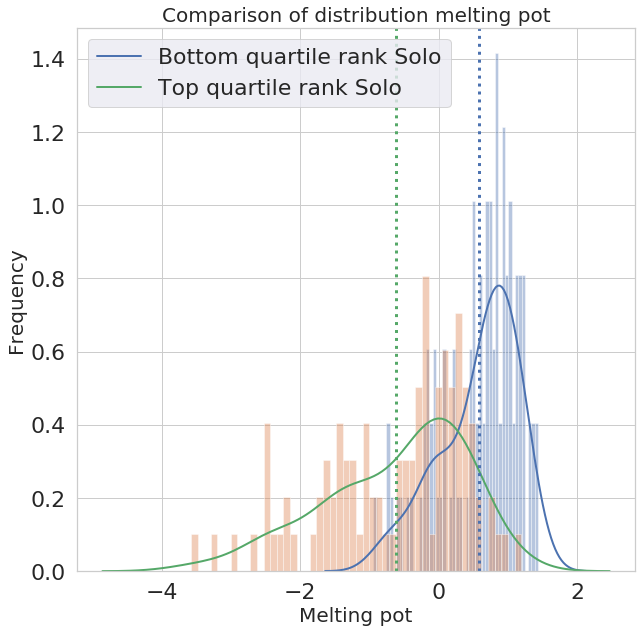

In [99]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.set(font_scale=2)
low_vals = solo_shape[solo_shape['Solo_area'] == 'low_solo']['z_NotBornUK_ratio']
high_vals = solo_shape[solo_shape['Solo_area'] == 'high_solo']['z_NotBornUK_ratio']
sns.distplot(low_vals ,kde_kws={"color": "b", "lw": 2, "label": "Bottom quartile rank Solo"},bins=50,norm_hist=True)
sns.distplot(high_vals , kde_kws={"color": "g", "lw": 2, "label": "Top quartile rank Solo"},bins=50,norm_hist=True)
ax.axvline(x=np.mean(low_vals), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.mean(high_vals), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.title("Comparison of distribution melting pot" , fontsize = 20)
plt.xlabel("Melting pot" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

Text(0, 0.5, 'Frequency')

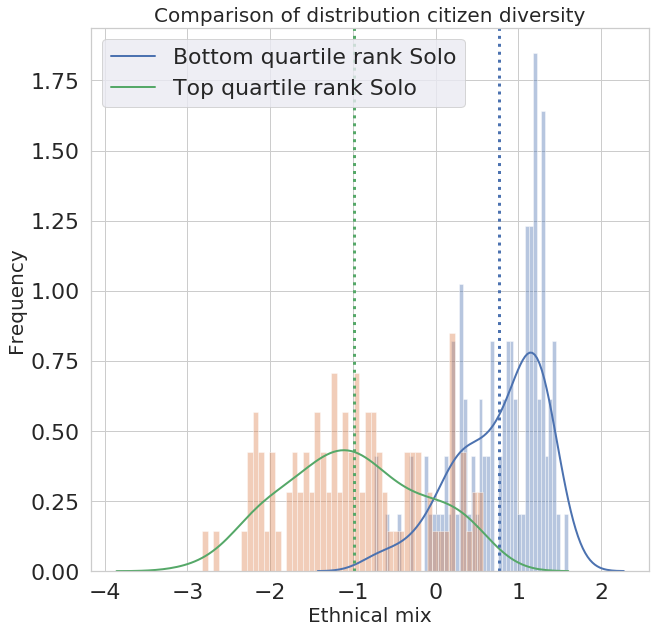

In [100]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.set(font_scale=2)
low_vals = solo_shape[solo_shape['Solo_area'] == 'low_solo']['zt_GiniSimpso']
high_vals = solo_shape[solo_shape['Solo_area'] == 'high_solo']['zt_GiniSimpso']
sns.distplot(low_vals ,kde_kws={"color": "b", "lw": 2, "label": "Bottom quartile rank Solo"},bins=50,norm_hist=True)
sns.distplot(high_vals , kde_kws={"color": "g", "lw": 2, "label": "Top quartile rank Solo"},bins=50,norm_hist=True)
ax.axvline(x=np.mean(low_vals), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.mean(high_vals), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.title("Comparison of distribution citizen diversity" , fontsize = 20)
plt.xlabel("Ethnical mix" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

Text(0, 0.5, 'Frequency')

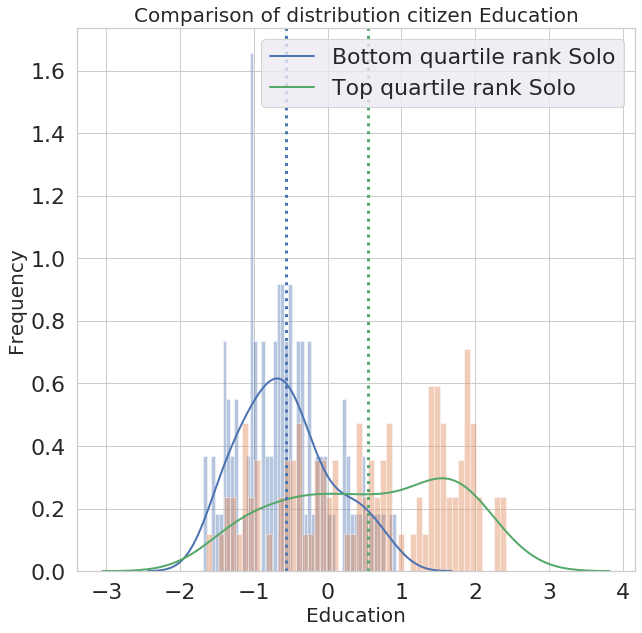

In [101]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.set(font_scale=2)
low_vals = solo_shape[solo_shape['Solo_area'] == 'low_solo']['z_PercLev4Qu']
high_vals = solo_shape[solo_shape['Solo_area'] == 'high_solo']['z_PercLev4Qu']
sns.distplot(low_vals ,kde_kws={"color": "b", "lw": 2, "label": "Bottom quartile rank Solo"},bins=50,norm_hist=True)
sns.distplot(high_vals , kde_kws={"color": "g", "lw": 2, "label": "Top quartile rank Solo"},bins=50,norm_hist=True)
ax.axvline(x=np.mean(low_vals), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.mean(high_vals), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.title("Comparison of distribution citizen Education" , fontsize = 20)
plt.xlabel("Education" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

Text(0, 0.5, 'Frequency')

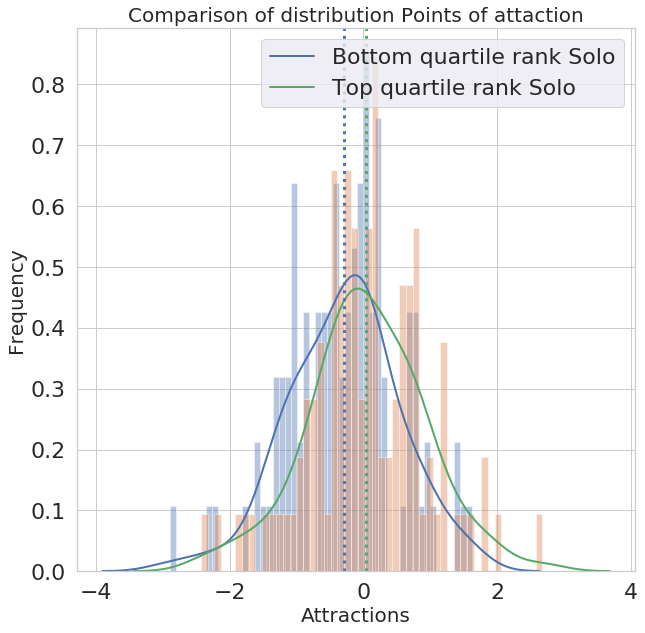

In [102]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.set(font_scale=2)
low_vals = solo_shape[solo_shape['Solo_area'] == 'low_solo']['zt_NoOSPOIs']
high_vals = solo_shape[solo_shape['Solo_area'] == 'high_solo']['zt_NoOSPOIs']
sns.distplot(low_vals ,kde_kws={"color": "b", "lw": 2, "label": "Bottom quartile rank Solo"},bins=50,norm_hist=True)
sns.distplot(high_vals , kde_kws={"color": "g", "lw": 2, "label": "Top quartile rank Solo"},bins=50,norm_hist=True)
ax.axvline(x=np.mean(low_vals), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.mean(high_vals), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.title("Comparison of distribution Points of attaction" , fontsize = 20)
plt.xlabel("Attractions" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

Text(0, 0.5, 'Frequency')

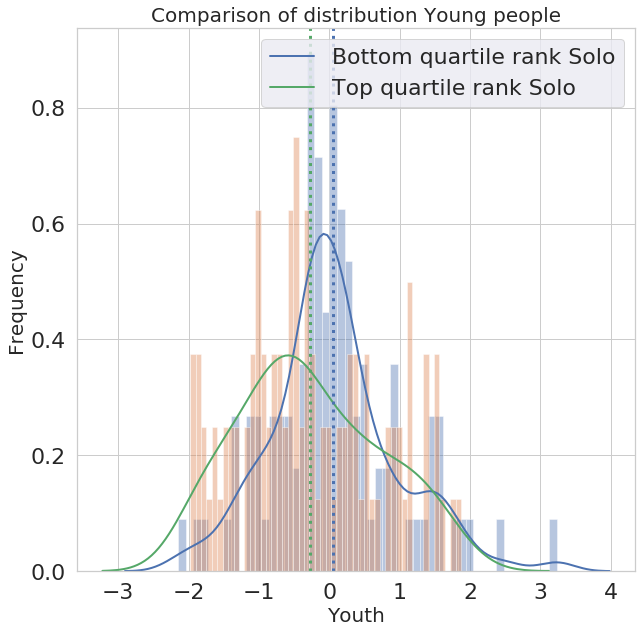

In [103]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.set(font_scale=2)
low_vals = solo_shape[solo_shape['Solo_area'] == 'low_solo']['zt_PopDen']
high_vals = solo_shape[solo_shape['Solo_area'] == 'high_solo']['zt_PopDen']
sns.distplot(low_vals ,kde_kws={"color": "b", "lw": 2, "label": "Bottom quartile rank Solo"},bins=50,norm_hist=True)
sns.distplot(high_vals , kde_kws={"color": "g", "lw": 2, "label": "Top quartile rank Solo"},bins=50,norm_hist=True)
ax.axvline(x=np.mean(low_vals), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.mean(high_vals), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.title("Comparison of distribution Young people" , fontsize = 20)
plt.xlabel("Youth" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [104]:
solo_shape['Sex_ratio'] = solo_shape['female']/solo_shape['male']

Text(0, 0.5, 'Frequency')

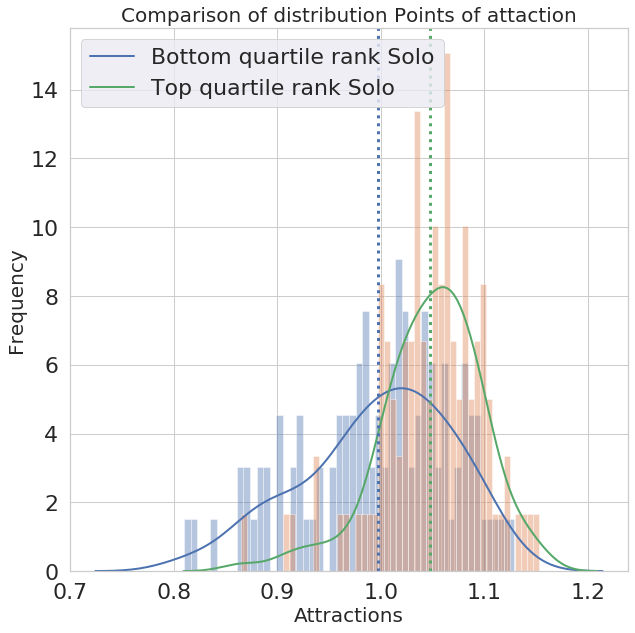

In [105]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.set(font_scale=2)
low_vals = solo_shape[solo_shape['Solo_area'] == 'low_solo']['Sex_ratio']
high_vals = solo_shape[solo_shape['Solo_area'] == 'high_solo']['Sex_ratio']
sns.distplot(low_vals ,kde_kws={"color": "b", "lw": 2, "label": "Bottom quartile rank Solo"},bins=50,norm_hist=True)
sns.distplot(high_vals , kde_kws={"color": "g", "lw": 2, "label": "Top quartile rank Solo"},bins=50,norm_hist=True)
ax.axvline(x=np.mean(low_vals), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.mean(high_vals), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.title("Comparison of distribution Points of attaction" , fontsize = 20)
plt.xlabel("Attractions" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [106]:
list(solo_shape.columns)

['NAME_x',
 'GSS_CODE_x',
 'DISTRICT_x',
 'LAGSSCODE_x',
 'HECTARES_x',
 'NONLD_AREA_x',
 'geometry_x',
 'Unnamed: 0',
 'Unnamed: 0_x',
 'green_score',
 'GSS_CODE_x',
 'WD17CD',
 'GLUD_Area of Greenspace PCT',
 'LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT',
 'Unnamed: 0.1',
 'borough_name_x',
 'poly',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Tree',
 'TreeTotal',
 'TreeScore',
 'psoriasis_Prescriptions',
 'psoriasis_Prevalence',
 "Meniere's disease_Prescriptions",
 "Meniere's disease_Prevalence",
 "crohn's disease_Prescriptions",
 "crohn's disease_Prevalence",
 'gastroparesis_Prescriptions',
 'gastroparesis_Prevalence',
 'irritable bowel syndrome_Prescriptions',
 'irritable bowel syndrome_Prevalence',
 'parkinson_Prescriptions',
 'parkinson_Prevalence',
 'sleep apnea_Prescriptions',
 'sleep apnea_Prevalence',
 'interstitial cystitis_Prescriptio

In [107]:
RSOS_subset = solo_shape[['GSS_CODE_x','NAME_x','depression_Prevalence','IMD','zt_GiniSimpso','z_PercLev4Qu']]

In [108]:
RSOS_subset = RSOS_subset.rename(columns={"GSS_CODE_x": "GSS_CODE", "NAME_x": "NAME", "depression_Prevalence": "presc_depression_prevalence", "zt_GiniSimpso":"Z_diversity" , "z_PercLev4Qu" : "Z_education"})

In [109]:
RSOS_subset.to_csv("RSOS_data/ward_data.csv")

In [110]:
data_analysis = solo_shape.copy()

import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn import preprocessing


socio_economic = ['people_per_sq_km','zt_GiniSimpso']
# nutrient = ['transaction_days' , 'weight' ,'num_transactions']
incidentals  = ['h_nutrients_calories','z_NotBornUK_ratio']
green = ['TreeScore_norm','GLUD_Area of Greenspace PCT','LCM_tree_pct','LCM_urban_pct','UA_Public Greenery PCT','StreetTrees_PCT']
beauty = ['bscore']
interaction_terms = ['interaction_0']


interactions = [('Median 2012/13' , 'h_nutrients_calories'),('All_jsa','h_nutrients_calories_norm'),('people_per_sq_km','h_nutrients_calories_norm')]


for index , i in enumerate(interactions):
    sampled = data_testing_all[[i[0] , i[1]]]
    normalized_sampled = (sampled-sampled.min())/(sampled.max()-sampled.min())
    data_analysis['interaction_'+str(index)] = normalized_sampled[i[0]] * normalized_sampled[i[1]]


X_dims = socio_economic 

print(X_dims)


Y_dims = ['rank']


min_max_scaler = preprocessing.MinMaxScaler() 

Y = np.array(data_analysis[Y_dims].values,dtype=np.float32)
X = np.array(data_analysis[X_dims].values,dtype=np.float32)

X = min_max_scaler.fit_transform(X)

Y = min_max_scaler.fit_transform(Y)

['people_per_sq_km', 'zt_GiniSimpso']


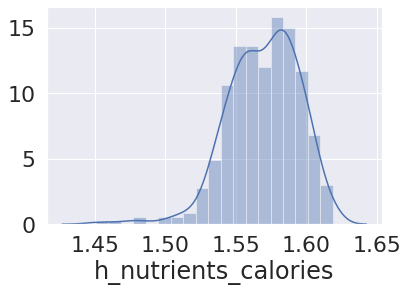

In [111]:
sns.distplot(data_analysis['h_nutrients_calories'])

[Text(0, 0.5, 'people_per_sq_km'), Text(0, 1.5, 'zt_GiniSimpso')]

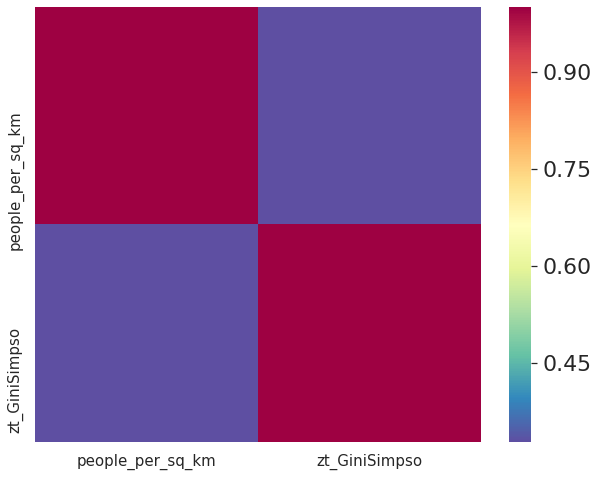

In [112]:
feats = data_analysis[X_dims]
fig, ax = plt.subplots(figsize=(10,8))         
corr = feats.corr(method='pearson')
sns.heatmap(corr, annot=False , ax=ax ,cmap='Spectral_r' )
ax.set_xticklabels(corr.columns, fontsize=15)
ax.set_yticklabels(corr.columns, fontsize=15)

In [113]:
print(X_dims)
X = sm.add_constant(X)
model_solo = sm.OLS(Y, X).fit()
model_solo.summary()

['people_per_sq_km', 'zt_GiniSimpso']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     181.4
Date:                Fri, 22 Jan 2021   Prob (F-statistic):           3.40e-57
Time:                        16:17:34   Log-Likelihood:                 53.884
No. Observations:                 414   AIC:                            -101.8
Df Residuals:                     411   BIC:                            -89.69
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0191      0.032     31.392      0.000       0.955       1.083
x1             0.2356      0.064      3.664      0.000       0.109       0.362
x2            -0.9407      0.050    -18.860      0.000      -1.039      -0.843
==============================================================================
Omnibus:                        0.779   Durbin-Watson:                   0.958
Prob(Omnibus):                  0.678   Jarque-Bera (JB):                0.872
Skew:                          -0.095   Prob(JB):                        0.647
Kurtosis:                       2.881   Cond. No.                         7.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
from scipy.stats import pearsonr
pearsonr(data_testing_all['people_per_sq_km'], data_testing_all['All_jsa'])

(0.20274631901612167, 3.238019532617474e-05)

In [115]:
data_testing_all.columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'green_score', 'GSS_CODE_x', 'WD17CD',
       'GLUD_Area of Greenspace PCT', 'LCM_grass_pct', 'LCM_tree_pct',
       'LCM_urban_pct', 'UA_Public Greenery PCT',
       ...
       'zt_ArtsEmploy_ratio', 'z_NotBornUK_ratio', 'z_PercLev4Qu',
       'z_LivingEnSc', 'zt_GrenSpace', 'zt_NoCTFtoH', 'z_NoHouses_ratio',
       'z_NoOwndDwel_ratio', 'zt_MedHPrice', 'zt_NoPropsSld'],
      dtype='object', length=345)

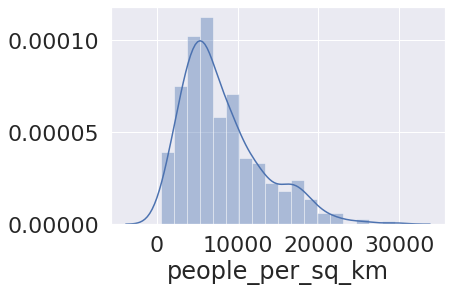

In [116]:
sns.distplot(data_testing_all['people_per_sq_km'])

In [117]:


import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn import preprocessing


socio_economic = ['z_NotBornUK_ratio', 'h_nutrients_calories','IMD' ,'people_per_sq_km']
# nutrient = ['transaction_days' , 'weight' ,'num_transactions']
incidentals  = ['rank' , 'Sex_ratio' , 'avg_age']
green = ['TreeScore_norm','GLUD_Area of Greenspace PCT','LCM_tree_pct','LCM_urban_pct','UA_Public Greenery PCT','StreetTrees_PCT']
beauty = ['bscore']
interaction_terms = ['interaction_0','interaction_1']


interactions = [('rank' , 'h_nutrients_calories'),('z_NotBornUK_ratio','IMD')]


for index , i in enumerate(interactions):
    sampled = data_testing_all[[i[0] , i[1]]]
    normalized_sampled = (sampled-sampled.min())/(sampled.max()-sampled.min())
    data_analysis['interaction_'+str(index)] = normalized_sampled[i[0]] * normalized_sampled[i[1]]


X_dims = socio_economic #+ incidentals + interaction_terms

print(X_dims)


Y_dims = ['depression_Prevalence']


min_max_scaler = preprocessing.MinMaxScaler() 

Y = np.array(data_analysis[Y_dims].values,dtype=np.float32)
X = np.array(data_analysis[X_dims].values,dtype=np.float32)

X = min_max_scaler.fit_transform(X)

Y = min_max_scaler.fit_transform(Y)

['z_NotBornUK_ratio', 'h_nutrients_calories', 'IMD', 'people_per_sq_km']


[Text(0, 0.5, 'z_NotBornUK_ratio'),
 Text(0, 1.5, 'h_nutrients_calories'),
 Text(0, 2.5, 'IMD'),
 Text(0, 3.5, 'people_per_sq_km')]

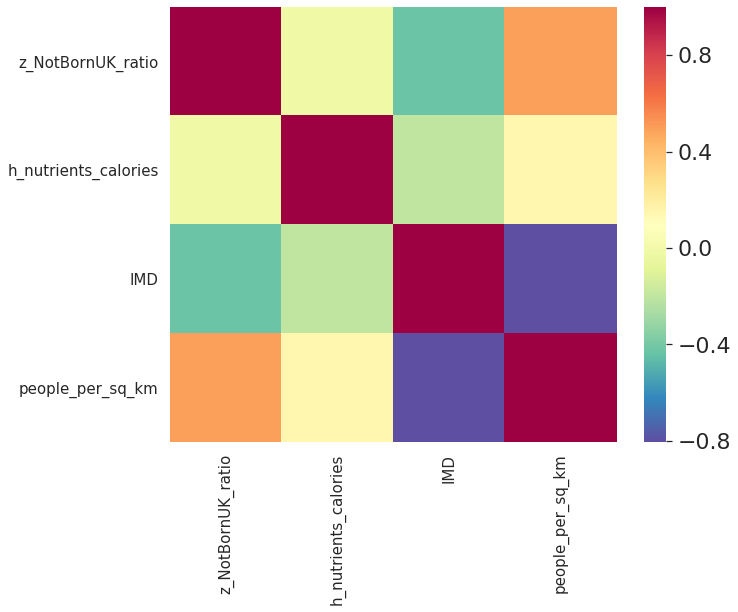

In [118]:
feats = data_analysis[X_dims]
fig, ax = plt.subplots(figsize=(10,8))         
corr = feats.corr(method='pearson')
sns.heatmap(corr, annot=False , ax=ax ,cmap='Spectral_r' )
ax.set_xticklabels(corr.columns, fontsize=15)
ax.set_yticklabels(corr.columns, fontsize=15)

In [119]:
print(X_dims)
X = sm.add_constant(X)
model_solo = sm.OLS(Y, X).fit()
model_solo.summary()

['z_NotBornUK_ratio', 'h_nutrients_calories', 'IMD', 'people_per_sq_km']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     20.51
Date:                Fri, 22 Jan 2021   Prob (F-statistic):           2.05e-15
Time:                        16:17:34   Log-Likelihood:                 255.71
No. Observations:                 414   AIC:                            -501.4
Df Residuals:                     409   BIC:                            -481.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5033      0.056      9.007      0.000       0.393       0.613
x1            -0.3103      0.041     -7.622      0.000      -0.390      -0.230
x2             0.1554      0.044      3.501      0.001       0.068       0.243
x3            -0.1015      0.053     -1.907      0.057      -0.206       0.003
x4             0.0366      0.066      0.557      0.578      -0.093       0.166
==============================================================================
Omnibus:                       11.962   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.363
Skew:                           0.376   Prob(JB):                      0.00207
Kurtosis:                       3.390   Cond. No.                         20.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""